In [1]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from IPython.display import Image

import time
from scipy.stats import ttest_ind, ttest_rel, chisquare, ks_2samp
import pandas as pd
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

from scipy import stats
from scipy.stats import mannwhitneyu

In [2]:
def p_value_calc(args):
    a,b, bins = args
    p=significance_of_mean(a,b, bins)[0]
    return p

### Load data from MC approximation of permutation test

In [3]:
def loadMcResult(sampleShape, mean):
    X_list = list()
    y_list = list()
    p_val_list = list()
    time_listMc = list()
    for S in sampleShape:
        X = pd.read_csv("dataFastPerm/data_{}/X_{}.csv".format(mean, S))
        Y = pd.read_csv("dataFastPerm/data_{}/y_{}.csv".format(mean, S))
        p_val = pd.read_csv("dataFastPerm/data_{}/error_{}.csv".format(mean, S))
        timeMc = pd.read_csv("dataFastPerm/data_{}/Time_{}.csv".format(mean, S))
    
    
        X.columns = range(X.shape[1])
        Y.columns = range(Y.shape[1])
        p_val.columns = range(p_val.shape[1])
        timeMc.columns = range(timeMc.shape[1])
    
    
        X_list.append([np.array(x.split(" ")[1:]).astype(float) for x in X[0].values])
        y_list.append([np.array(y.split(" ")[1:]).astype(float) for y in Y[0].values])
        p_val_list.append(np.array([float(p[0].split(" ")[1]) for p in p_val.values]))
        time_listMc.append([float(t[0].split(" ")[1]) for t in timeMc.values])
    
    return X_list, y_list, p_val_list, time_listMc

### Get p-value for the the parallelized permutation test

In [4]:
def run_test(X,Y,bins, parallel=True, midP=False):

    
    
    if parallel:
        #Exact test
        SGM = significance_of_mean_cuda(bins, dtype_v=np.uint32,dtype_A=np.float64)
        SGM.run(X.reshape(1,-1),Y.reshape(1,-1), midP)
        p_val = SGM.p_values[0]
    else:
        p_val = p_value_calc([list(X), list(Y), bins])

    return p_val

### Get all p-values from the prallelized exact test from the same data as the MC version

In [5]:
def shiftMethod(X_list, y_list, bins, parallel=True, midP=False):
    pe_list = list()
    TIME = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_e = list()
        time_list = list()
    
        for x, y in zip(Xp, yp):
            
            start = time.time()
            p_e.append(run_test(y, x, bins, parallel, midP))
            end = time.time()
        
            time_list.append(end - start)
    
        pe_list.append(p_e)
        TIME.append(time_list)
    
    return pe_list, TIME
    

In [6]:
def ttest(X_list, y_list):
    pt_list = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_t = list()
    
        for x, y in zip(Xp, yp):
            
            t, p = ttest_ind(y, x)
            p = p/2
            if t<0:
                p = 1-p
       
            p_t.append(p)
            
        pt_list.append(p_t)

    
    return pt_list
    

In [7]:
def mannWhitney(X_list, y_list, alternative="less"):
    assert alternative in ["less","greater","two-tail"]
    pmw_list = list()

    for Xp, yp in zip(X_list, y_list):
        Xp = np.asarray(Xp).T
        yp = np.asarray(yp).T
        
        p_mw = list()
    
        for x, y in zip(Xp, yp):
            

            p = mannwhitneyu(x, y, alternative=alternative)[1]
            
            
            p_mw.append(p)
            
        pmw_list.append(p_mw)

    
    return pmw_list

### Compare parallelized and MC version

In [8]:
def compare(p_val_list, pe_list, pt_list, pmw_list):
    PE_err = list()
    PAE_err = list()
    PMW_err = list()
    
    for P_ae, P_e, P_t, P_mw in zip(p_val_list, pe_list, pt_list, pmw_list):
        P_ae_error = list()
        P_e_error = list()
        P_mw_error = list()
        
        for ae, e, t, mw in zip(P_ae, P_e, P_t, P_mw):
            P_ae_error.append((ae - t) / t)
            P_e_error.append((e - t) / t)
            P_mw_error.append((mw - t) / t)
            
        PE_err.append(P_e_error)
        PAE_err.append(P_ae_error)
        PMW_err.append(P_mw_error)
    
    return PE_err, PAE_err, PMW_err


In [289]:
def preparePandas(timeData, sampleSizes, label=None):
    preparePd = list()
    for time, sample in zip(timeData, sampleSizes):
        preparePd.append([time, sample, label])
    return preparePd
    
    
class barPlot:
    def __init__(self, verbose=None):
        self.verbose = verbose

    def getData(self, p_list, p_tresh):
        falseNegativeList = list()
        
        for ix, p in enumerate(p_list):
            missed_p = sum(p_tresh < np.array(p))
            if self.verbose:
                print(missed_p)
            falseNegativeList.append(missed_p)
        return falseNegativeList
    

    def getPlot(self, pt_list,pe_list, pmw_list,p_val_list,p_tresh = 0.01, verbose=False):
    
        if self.verbose:
            print("T-test: ")
        missedP_t = self.getData(pt_list, p_tresh)
    
    
        if self.verbose:
            print("Exaxt test: ")
        missedP_e = self.getData(pe_list, p_tresh)

        if self.verbose:
            print("Mann-whitney: ")
        missed_mw = self.getData(pmw_list, p_tresh)
    
        if self.verbose:
            print("Fast approx: ")
        missed_fa = self.getData(p_val_list, p_tresh)

    
        d_t = preparePandas(missedP_t, sampleShape, label="t-test")
        d_e = preparePandas(missedP_e, sampleShape, label="shift method")
        d_mw = preparePandas(missed_mw, sampleShape, label="Mann Whitney test")
        d_fa = preparePandas(missed_fa, sampleShape, label="Fast approximation method")
        
        val1 = np.asarray(d_e)[:,0].astype(int)
        val2 = np.asarray(d_mw)[:,0].astype(int)
        val3 = np.asarray(d_fa)[:,0].astype(int)
        
        
        #print(np.argmin(np.asarray([val1, val2, val3]), axis=0))
        X = np.asarray([val1, val2, val3])
        
        mathods = ["shift method", "Mann Whitney test", "Fast approximation method"]
        M_S = [0,0,0]
        for x in X.T:    
            m= np.min(x, axis=0)
            ix = [i for i, j in enumerate(x) if j == m]
            for i in ix:
                M_S[i] += 1
                #print(M[i])
            #print([i for i, j in enumerate(x) if j == m])
        print("Score for treshold: {}".format(p_tresh))
        print("Score=#Number of time with least False Negatives")
        for score, method in zip(M_S, mathods):
            print("---- Method: {} with score {}".format(method, score))
        
        #for i in np.argmin(np.asarray([val1, val2, val3]), axis=0):
        #    print(["shift method", "Mann Whitney test", "Fast approximation method"][i])


        data = d_t + d_e + d_mw + d_fa
    
        pdData = pd.DataFrame(data, columns=['False negative','n', 'Method'])

        plt.title("P-treshold {}".format(i))
        sns.barplot(x="n", y="False negative", data=pdData, hue="Method")
        
    

In [259]:
val1 = np.asarray(d_e)[:,0].astype(int)

In [260]:
val2 = np.asarray(d_mw)[:,0].astype(int)

In [261]:
val3 = np.asarray(d_fa)[:,0].astype(int)

In [265]:
X = np.asarray([val1, val2, val3])

In [268]:
np.min(X, axis=0)

array([13,  0,  0,  0,  0,  0,  0])

In [272]:
for x in X.T:
    
    m= np.min(x, axis=0)
    print([i for i, j in enumerate(x) if j == m])
    

[1]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


In [ ]:
>>> m = max(a)
>>> [i for i, j in enumerate(a) if j == m]

In [251]:
np.argsort(np.asarray([val1, val2]), axis=0)

array([[0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1]])

In [252]:
def my_argmax(a):
    rows = np.where(a == a.max(axis=1)[:, None])[0]
    rows_multiple_max = rows[:-1][rows[:-1] == rows[1:]]
    my_argmax = a.argmax(axis=1)
    my_argmax[rows_multiple_max] = -1
    return my_argmax

In [253]:
my_argmax(np.asarray([val1, val2]))

array([0, 0])

In [ ]:
for v1, v2, v3 in zip(val1, val2, val3):
    

In [262]:
val1 == val2

array([False,  True,  True,  True,  True,  True,  True])

In [263]:
val1 == val3

array([False,  True,  True,  True,  True,  True,  True])

In [264]:
val2 == val3

array([False,  True,  True,  True,  True,  True,  True])

# Experiment 1: with $X \sim N(5.0,1)$ and $Y\sim N(5.2,1)$

In [17]:
mean = 5.2

In [18]:
X_list5_2, y_list5_2, p_val_list5_2, time_listMc5_2 = loadMcResult(sampleShape, mean)

In [19]:
pe_list5_2, TIME5_2 = shiftMethod(np.asarray(X_list5_2), np.asarray(y_list5_2), 40)
pt_list5_2 = ttest(np.asarray(X_list5_2), np.asarray(y_list5_2))
pmw_list5_2 = mannWhitney(np.asarray(X_list5_2), np.asarray(y_list5_2))

Score for treshold: 0.05
Score=#Number of time with least False Negatives
---- Method: shift method with score 4
---- Method: Mann Whitney test with score 3
---- Method: Fast approximation method with score 0
Score for treshold: 0.04
Score=#Number of time with least False Negatives
---- Method: shift method with score 5
---- Method: Mann Whitney test with score 3
---- Method: Fast approximation method with score 0
Score for treshold: 0.03
Score=#Number of time with least False Negatives
---- Method: shift method with score 5
---- Method: Mann Whitney test with score 3
---- Method: Fast approximation method with score 1
Score for treshold: 0.02
Score=#Number of time with least False Negatives
---- Method: shift method with score 5
---- Method: Mann Whitney test with score 4
---- Method: Fast approximation method with score 1
Score for treshold: 0.01
Score=#Number of time with least False Negatives
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 3
---- Me

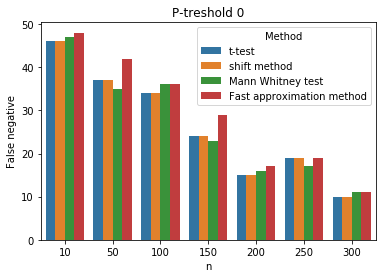

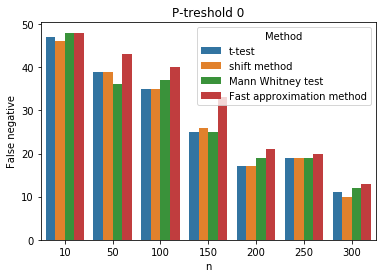

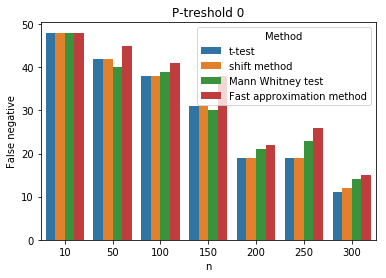

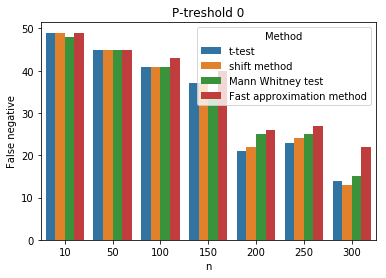

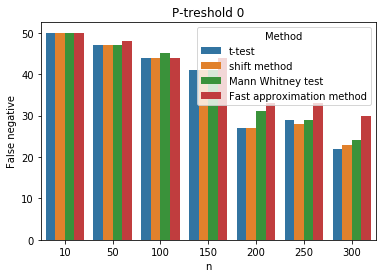

In [290]:
plot = barPlot()

for i in np.linspace(0.01, 0.05, 5)[::-1]:
    plt.figure()
    plot.getPlot(pt_list5_2, pe_list5_2, pmw_list5_2, p_val_list5_2, i)

# Experiment 2: with $X \sim N(5.0,1)$ and $Y\sim N(5.4,1)$

In [215]:
mean = 5.4
X_list5_4, y_list5_4, p_val_list5_4, time_listMc5_4 = loadMcResult(sampleShape, mean)

In [216]:
pe_list5_4, TIME5_4 = shiftMethod(np.asarray(X_list5_4), np.asarray(y_list5_4), 40)


pt_list5_4 = ttest(np.asarray(X_list5_4), np.asarray(y_list5_4))
pmw_list5_4 = mannWhitney(np.asarray(X_list5_4), np.asarray(y_list5_4))


Score for treshold: 0.05
Score=#Number of time with least False Negatives
---- Method: shift method with score 6
---- Method: Mann Whitney test with score 4
---- Method: Fast approximation method with score 3
Score for treshold: 0.04
Score=#Number of time with least False Negatives
---- Method: shift method with score 6
---- Method: Mann Whitney test with score 5
---- Method: Fast approximation method with score 3
Score for treshold: 0.03
Score=#Number of time with least False Negatives
---- Method: shift method with score 6
---- Method: Mann Whitney test with score 4
---- Method: Fast approximation method with score 3
Score for treshold: 0.02
Score=#Number of time with least False Negatives
---- Method: shift method with score 5
---- Method: Mann Whitney test with score 4
---- Method: Fast approximation method with score 2
Score for treshold: 0.01
Score=#Number of time with least False Negatives
---- Method: shift method with score 6
---- Method: Mann Whitney test with score 3
---- Me

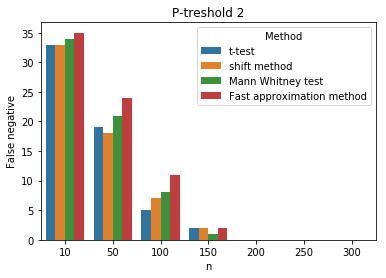

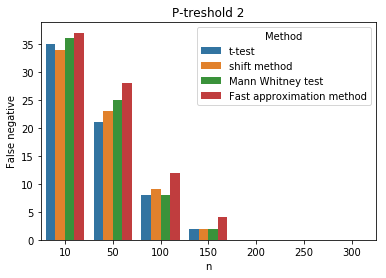

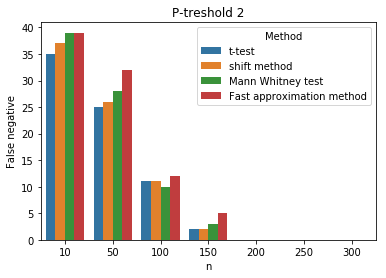

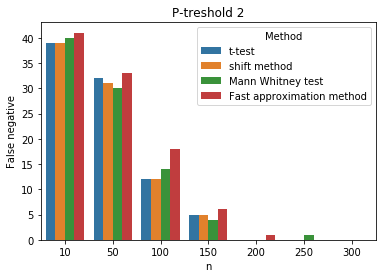

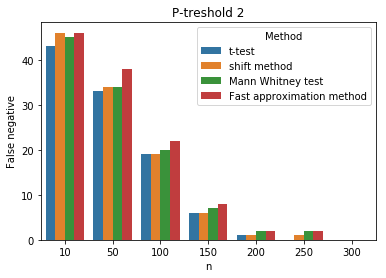

In [291]:
plot = barPlot()

for i in np.linspace(0.01, 0.05, 5)[::-1]:
    plt.figure()
    plot.getPlot(pt_list5_4, pe_list5_4, pmw_list5_4, p_val_list5_4, i)

# Experiment 3: with $X \sim N(5.0,1)$ and $Y\sim N(5.6,1)$

In [284]:
mean=5.6
X_list5_6, y_list5_6, p_val_list5_6, time_listMc5_6 = loadMcResult(sampleShape, mean)

In [285]:
pe_list5_6, TIME5_4 = shiftMethod(np.asarray(X_list5_6), np.asarray(y_list5_6), 40)


pt_list5_6 = ttest(np.asarray(X_list5_6), np.asarray(y_list5_6))
pmw_list5_6 = mannWhitney(np.asarray(X_list5_6), np.asarray(y_list5_6))

---- Method: shift method with score 6
---- Method: Mann Whitney test with score 6
---- Method: Fast approximation method with score 5
---- Method: shift method with score 6
---- Method: Mann Whitney test with score 6
---- Method: Fast approximation method with score 5
---- Method: shift method with score 6
---- Method: Mann Whitney test with score 7
---- Method: Fast approximation method with score 4
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 6
---- Method: Fast approximation method with score 5
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 4
---- Method: Fast approximation method with score 3


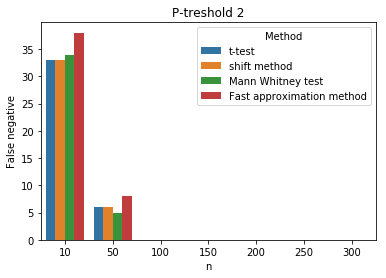

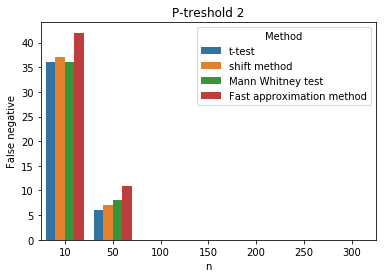

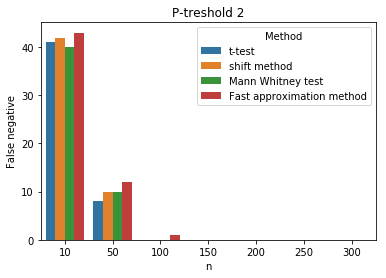

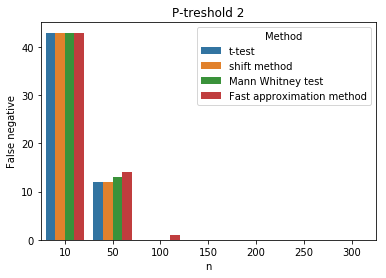

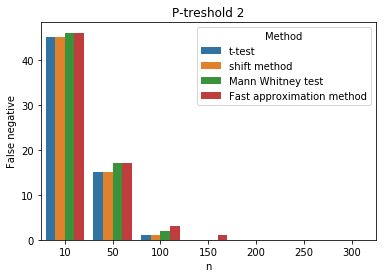

In [286]:
plot = barPlot()

for i in np.linspace(0.01, 0.05, 5)[::-1]:
    plt.figure()
    plot.getPlot(pt_list5_6, pe_list5_6, pmw_list5_6, p_val_list5_6, i)

# Experiment 4: with $X \sim N(5.0,1)$ and $Y\sim N(5.8,1)$

In [218]:
mean=5.8
X_list5_8, y_list5_8, p_val_list5_8, time_listMc5_8 = loadMcResult(sampleShape, mean)

In [219]:
pe_list5_8, TIME5_8 = shiftMethod(np.asarray(X_list5_8), np.asarray(y_list5_8), 40)
pt_list5_8 = ttest(np.asarray(X_list5_8), np.asarray(y_list5_8))
pmw_list5_8 = mannWhitney(np.asarray(X_list5_8), np.asarray(y_list5_8))

Score for treshold: 0.05
Score=#Number of time with least False Negatives
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 5
---- Method: Fast approximation method with score 5
Score for treshold: 0.04
Score=#Number of time with least False Negatives
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 6
---- Method: Fast approximation method with score 6
Score for treshold: 0.03
Score=#Number of time with least False Negatives
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 5
---- Method: Fast approximation method with score 6
Score for treshold: 0.02
Score=#Number of time with least False Negatives
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 5
---- Method: Fast approximation method with score 5
Score for treshold: 0.01
Score=#Number of time with least False Negatives
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 6
---- Me

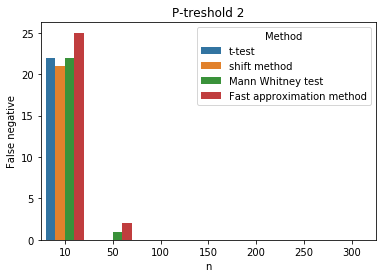

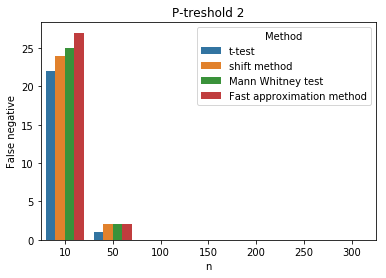

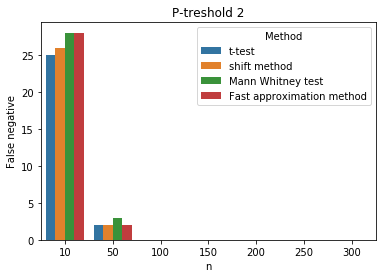

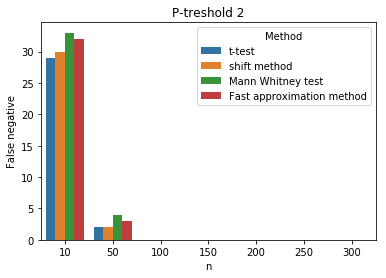

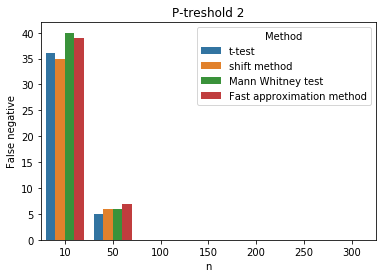

In [292]:
plot = barPlot()

for i in np.linspace(0.01, 0.05, 5)[::-1]:
    plt.figure()
    plot.getPlot(pt_list5_8, pe_list5_8, pmw_list5_8, p_val_list5_8, i)

# Experiment 5: with $X \sim N(5.0,1)$ and $Y\sim N(6.0,1)$

In [221]:
mean=6.0
X_list6_0, y_list6_0, p_val_list6_0, time_listMc6_0 = loadMcResult(sampleShape, int(mean))

In [222]:
pe_list6_0, TIME5_8 = shiftMethod(np.asarray(X_list6_0), np.asarray(y_list6_0), 40)
pt_list6_0 = ttest(np.asarray(X_list6_0), np.asarray(y_list6_0))
pmw_list6_0 = mannWhitney(np.asarray(X_list6_0), np.asarray(y_list6_0))

Score for treshold: 0.05
Score=#Number of time with least False Negatives
---- Method: shift method with score 6
---- Method: Mann Whitney test with score 7
---- Method: Fast approximation method with score 6
Score for treshold: 0.04
Score=#Number of time with least False Negatives
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 7
---- Method: Fast approximation method with score 6
Score for treshold: 0.03
Score=#Number of time with least False Negatives
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 7
---- Method: Fast approximation method with score 6
Score for treshold: 0.02
Score=#Number of time with least False Negatives
---- Method: shift method with score 6
---- Method: Mann Whitney test with score 7
---- Method: Fast approximation method with score 6
Score for treshold: 0.01
Score=#Number of time with least False Negatives
---- Method: shift method with score 7
---- Method: Mann Whitney test with score 6
---- Me

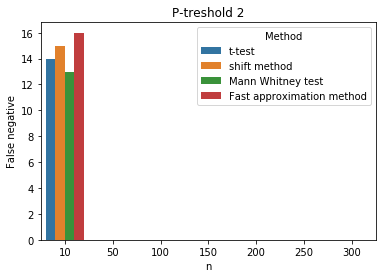

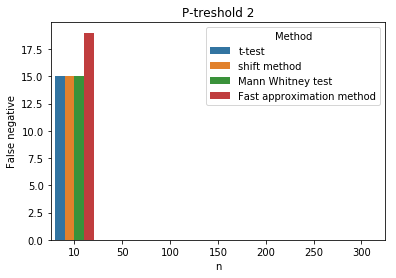

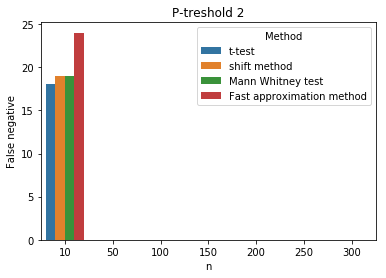

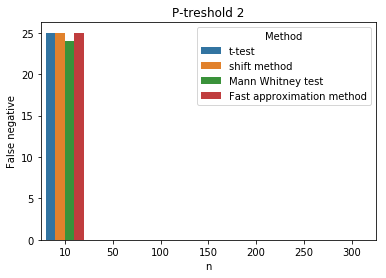

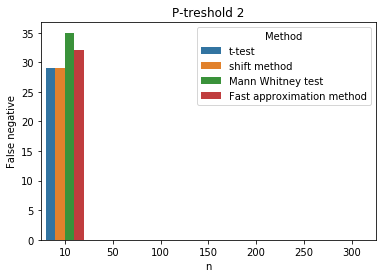

In [293]:
plot = barPlot()

for i in np.linspace(0.01, 0.05, 5)[::-1]:
    plt.figure()
    plot.getPlot(pt_list6_0, pe_list6_0, pmw_list6_0, p_val_list6_0, i)